In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
#import keras
from matplotlib import rc
rc("text", usetex=True)
rc("font", family = "serif")
rc("figure",figsize=(6,4))
%config InlineBackend.figure_format = 'retina'
from phase_mixing_utils import *
from skimage import data
import skimage
import matplotlib as mpl

In [2]:
def sq_lat(n,p):
    """Generate a nxn square lattice with period p
        The first lattice point is at [(p-1)/2,(p-1)/2"""
    lattice = np.zeros((n,n))
    for i in range(40):
        for j in range(40):
            lattice[(p-1)/2+p*i,(p-1)/2+p*j] = 1
    return lattice
lat = sq_lat(200,5)

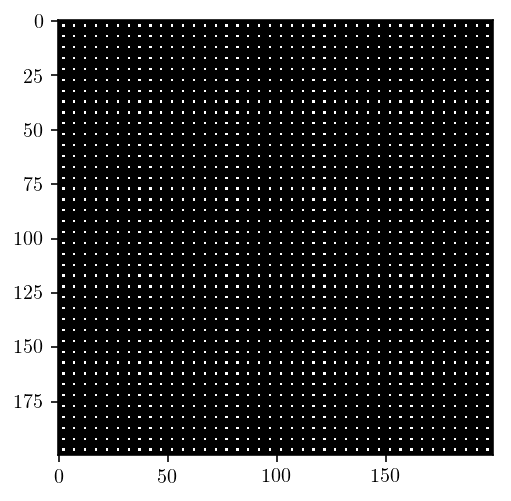

In [3]:
plt.imshow(lat,cmap="gray")
plt.show()

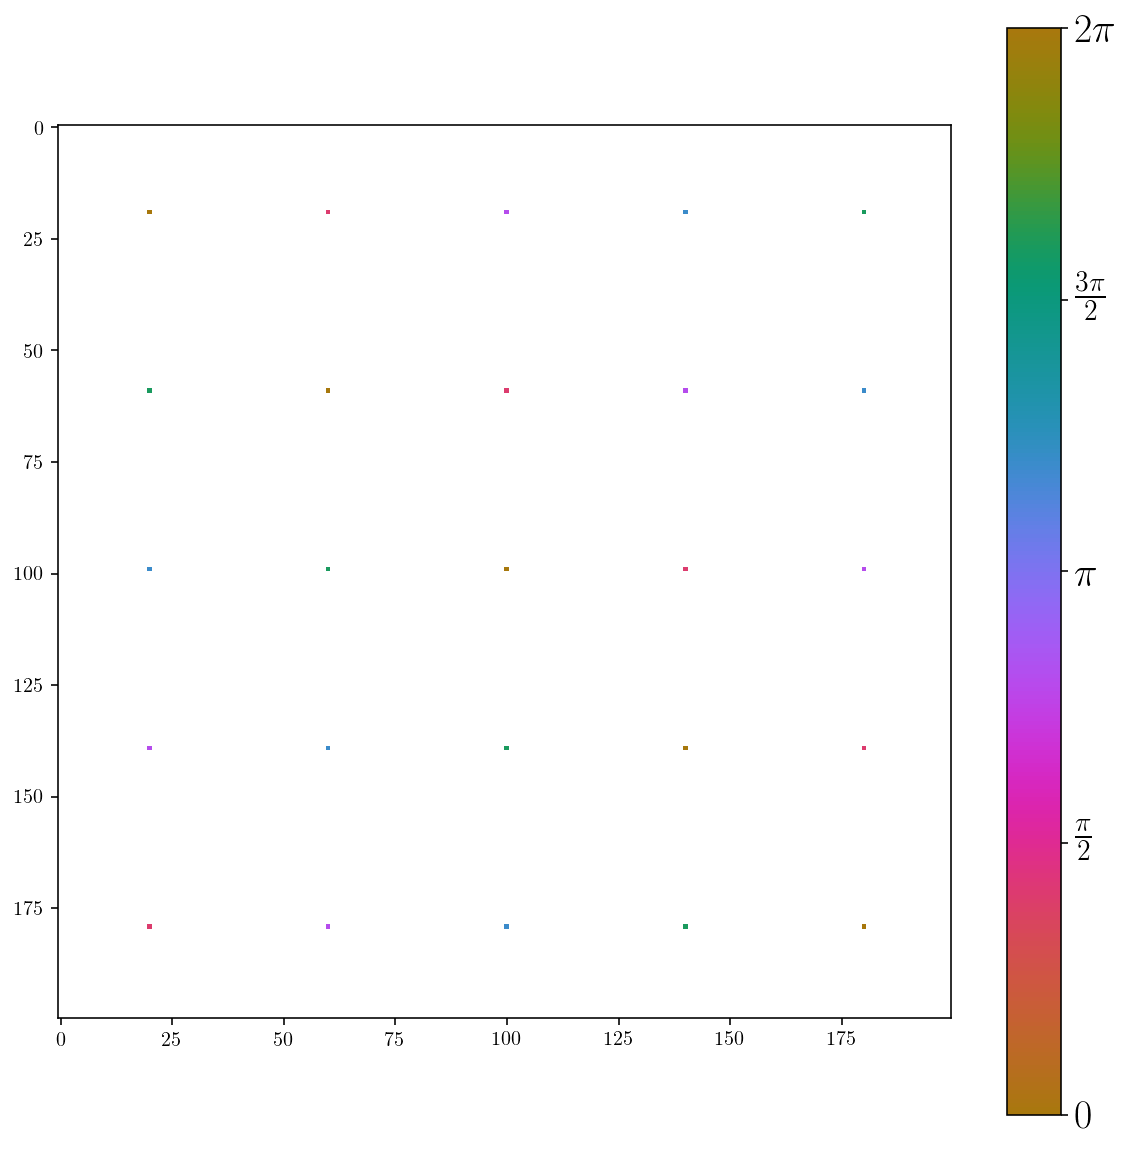

In [7]:
ft_lat = np.fft.fft2(lat)
phase_intensity_plot(np.fft.fftshift(ft_lat))
plt.show()

FT of sqare lattice is a sqare lattice 

Try a lattice with structure - square lattice with a 3 pixel L basis

In [5]:
unit_cell = np.zeros((5,5))
unit_cell[3,3]=1
unit_cell[3,2]=1
unit_cell[2,3]=1
lat2 = np.tile(unit_cell,(40,40))
plt.figure(figsize=(10,10))
plt.imshow(lat2)
#plt.show()

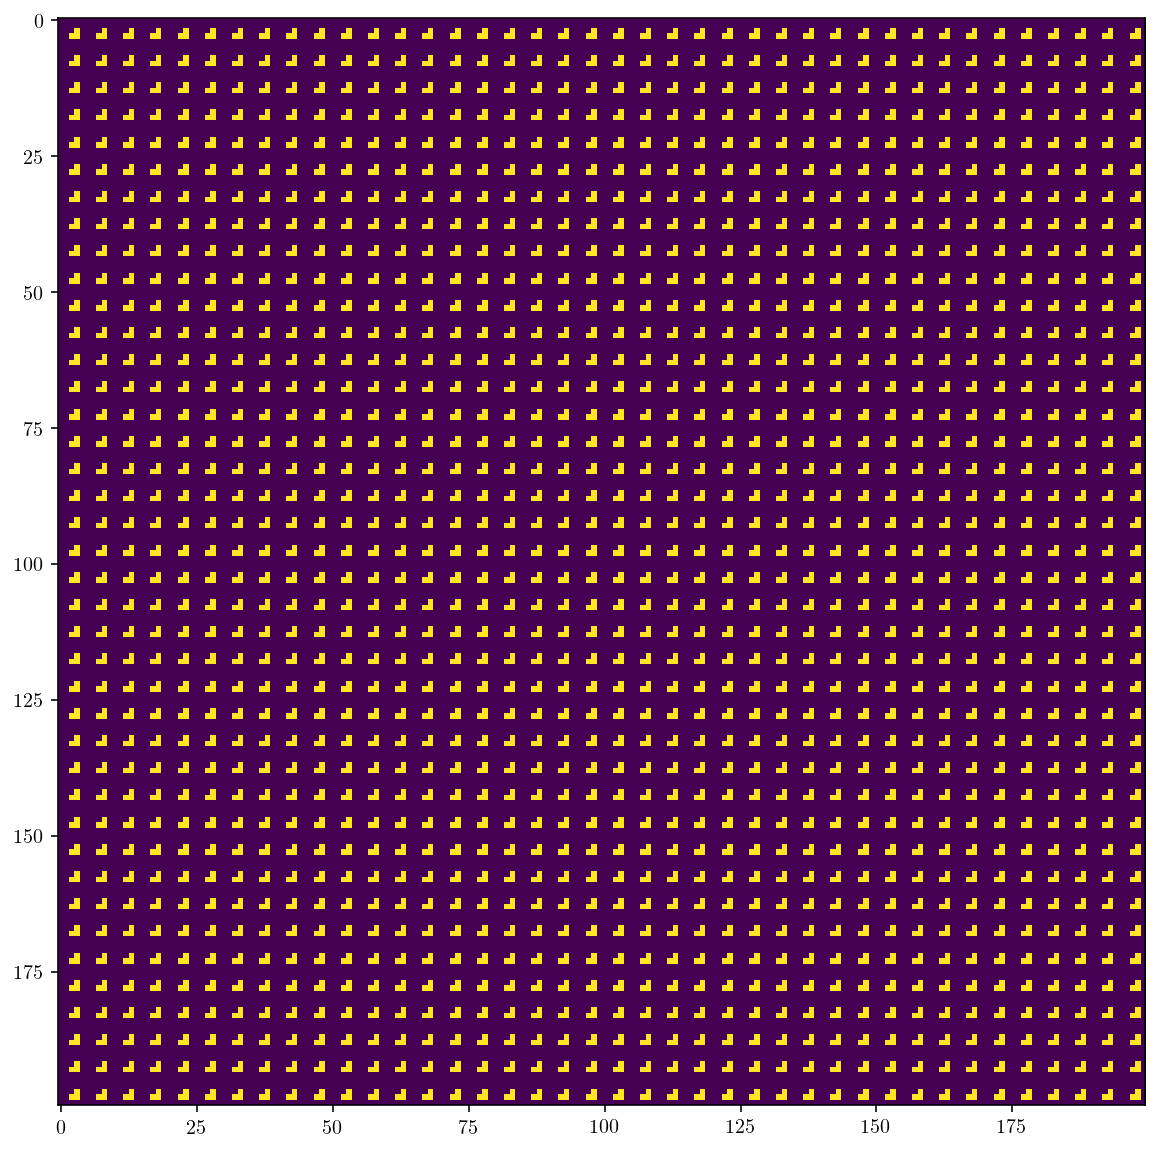

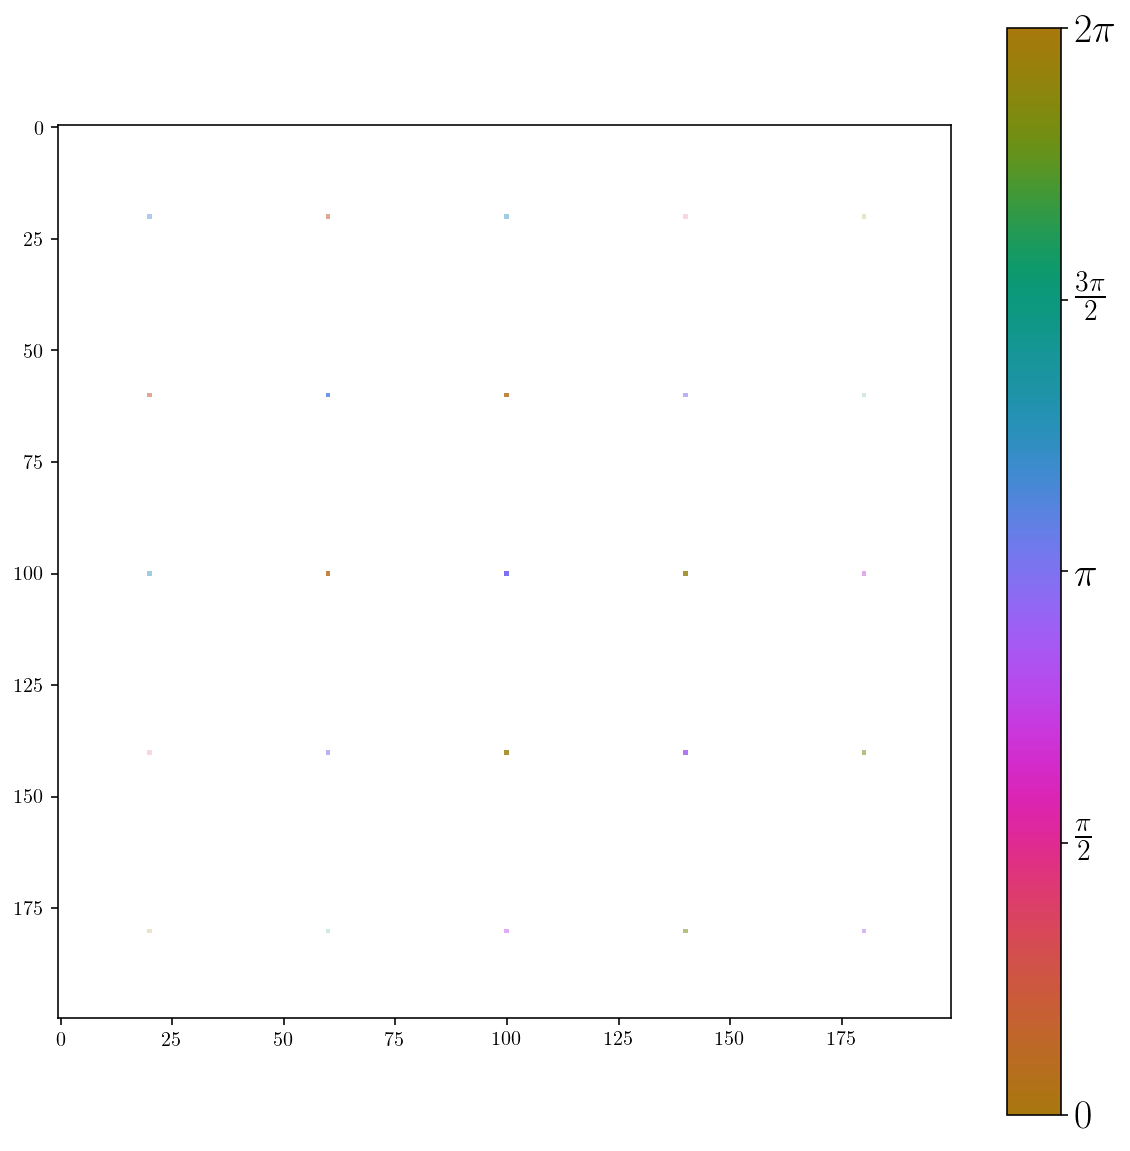

In [6]:
ft_lat2 = np.fft.fft2(lat2)
phase_intensity_plot(np.fft.fftshift(ft_lat2))

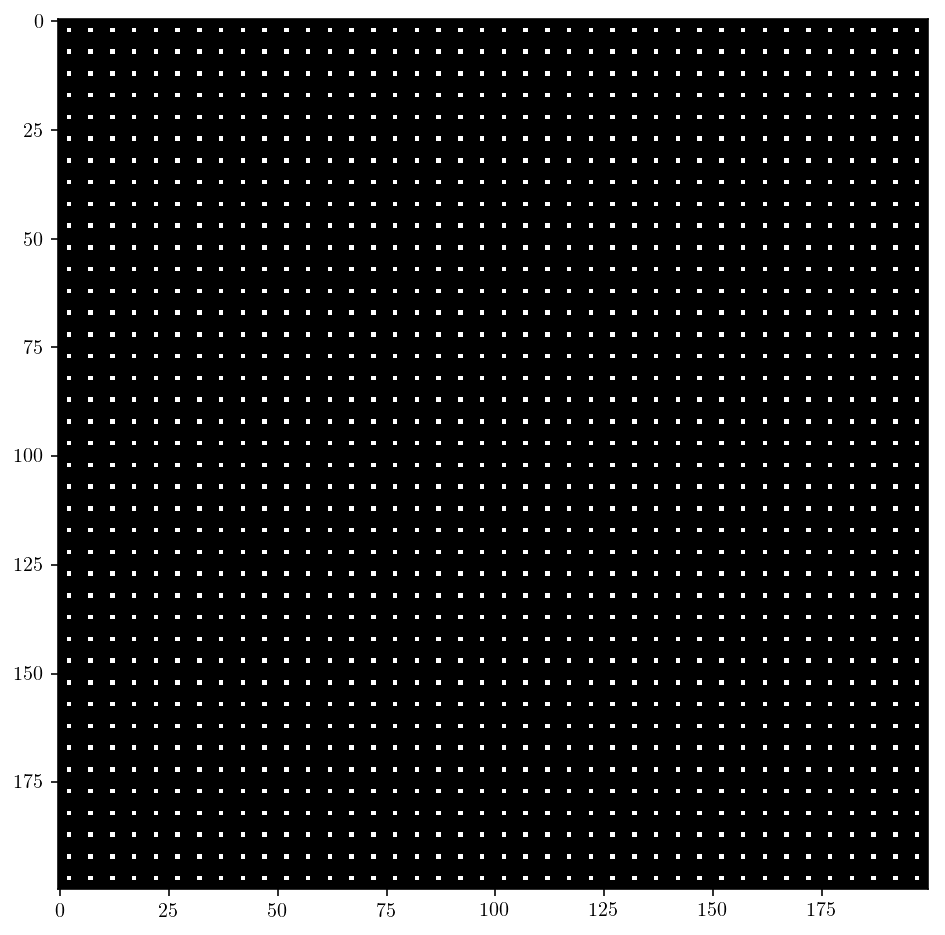

In [7]:
smpl_sq_mag = get_mag(ft_lat)
basis_sq_phase = get_phase(ft_lat2)
basis_smpl = mix_FT(lat,lat)
#phase_intensity_plot(basis_smpl)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(np.real(np.fft.ifft2(basis_smpl)),cmap="gray")
plt.show()

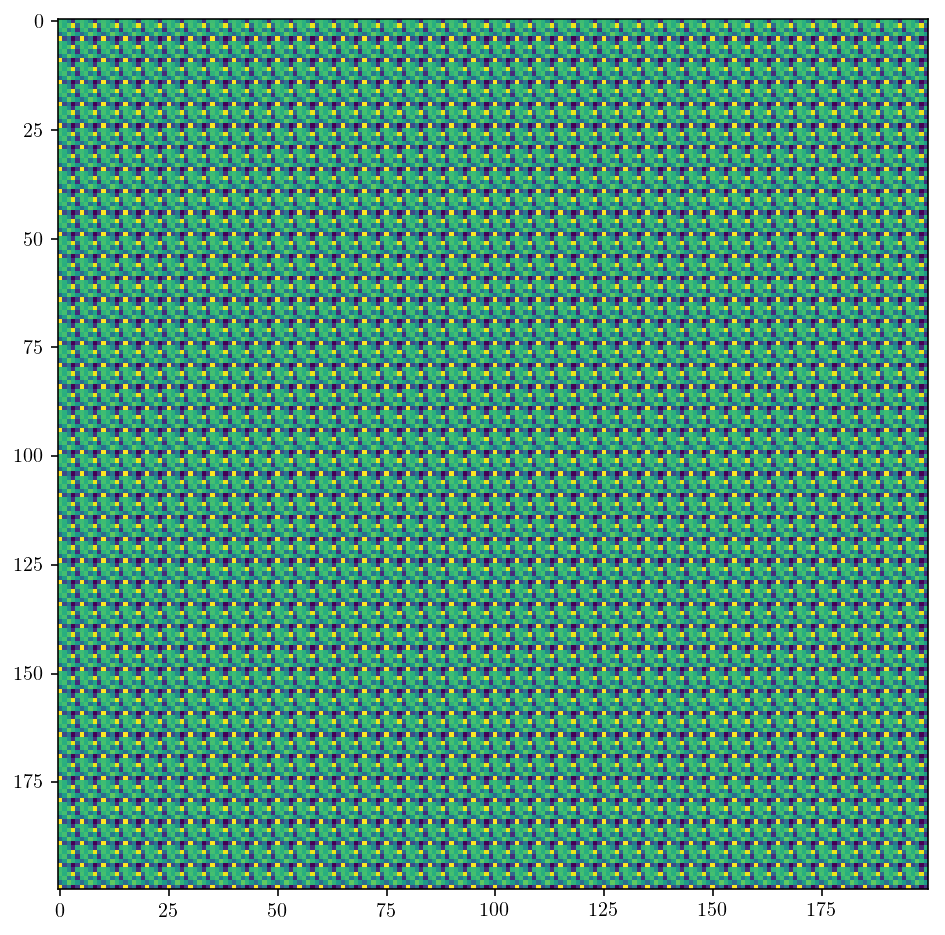

In [8]:
random = np.random.random((200,200))
smpl_sq_rphases = mix_FT(lat,random)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(np.real(np.fft.ifft2(smpl_sq_rphases)))
plt.show()

In [9]:
from scipy.stats import multivariate_normal

In [61]:
# Note this is not consistent with the gaussian lattice function in phase_mixing_utils
#This one lets you set the variance of each gaussian with the r parameter
def gaussian_lattice(n_atoms,uc_size,n_tiles, means, r):
    """ Create a square lattice composed of unit cells each containg n_atoms gaussians of unit variance
        Lattice dimensions are (uc_size*n_tiles)x(uc_size*n_tiles)
        Means is an array of locations for the gaussians - each value must be less than uc_size
        r is variance of each gaussian
        Output is an array containg the lattice"""
    uc = np.zeros((uc_size,uc_size))
    X,Y = np.meshgrid(np.arange(uc_size),np.arange(uc_size))
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    for i in range(n_atoms):
        mvn = multivariate_normal(mean=means[i],cov = r)
        uc = uc + mvn.pdf(pos)
    #return uc
    return np.tile(uc,(n_tiles,n_tiles))

In [62]:
mu = np.array([[20,20],[50,90],[80,30]])

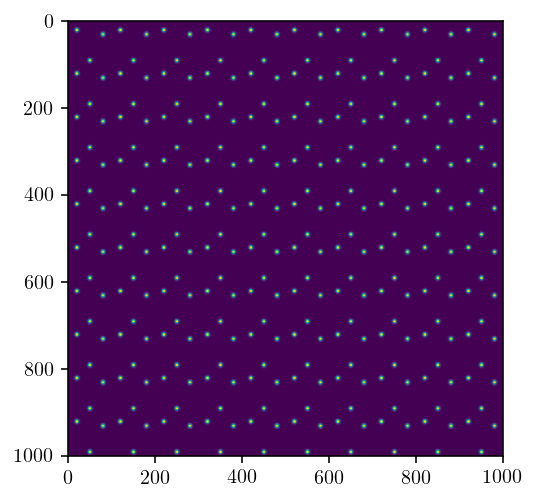

In [63]:
plt.imshow(gaussian_lattice(3,100,10,mu,10))
plt.show()

In [64]:
def_uc = 100
th = np.linspace(0,2*np.pi,11)
circ_mu = np.array([[def_uc/2+(def_uc/3)*np.cos(t),def_uc/2+(def_uc/3)*np.sin(t)] for t in th[:-1]])

In [65]:
rings = gaussian_lattice(10,def_uc,10, circ_mu,10)
ft_rings = np.fft.fft2(rings)

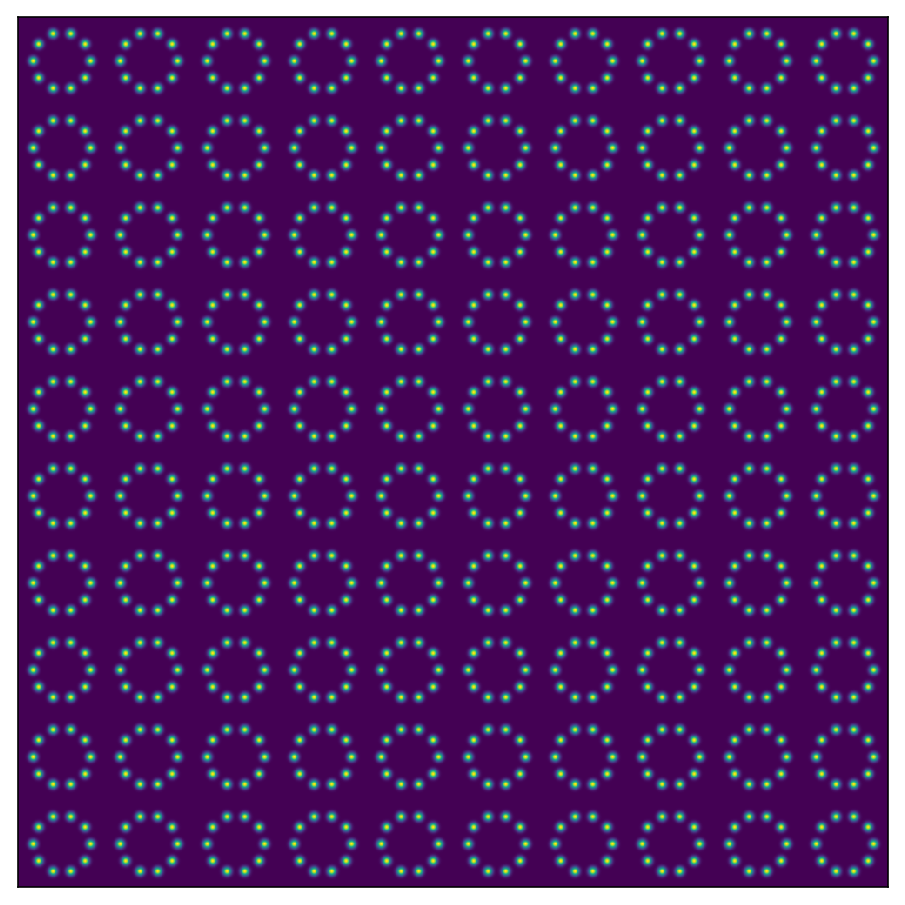

In [66]:
plt.figure(figsize=(8,8))
plt.imshow(rings)
plt.xticks([])
plt.yticks([])
#phase_intensity_plot(ft_rings)
plt.show()

In [95]:
#Modified Bessel functions (for SnB cost function)
from scipy.special import iv

In [128]:
def ks_err(guess,answer): 
    g = np.ravel(guess)
    a = np.ravel(answer)
    abs_err = np.sum((np.abs(g)-np.abs(a))**2)
    norm = np.sum(np.abs(a)**2)
    return abs_err/norm

On a tip from Kevin, I enforce the positive constraint only on the unit cell and only tile it to take the FFT (side note, in some reference they mention zero padding the array? perhaps something to consider.

In [285]:
#uc = gaussian_lattice(10,1000,1,circ_mu,10)
uc = rings[:100,:100]
mt = np.fft.fft2(uc)
mags = get_mag(ft_rings)
phases = get_phase(mt)
n_iters = 100
rs_const = gaussian_lattice(1,def_uc,1,np.array([[50,50]]),500) #Guess a gaussian centered in the middle of the uc
arb_centers = [[10,10],[10,30],[40,20],[50,20],[50,50],[30,60],[60,80],[80,60],[20,60],[50,80]]
#rs_const = gaussian_lattice(10,def_uc,1,arb_centers,10) #Guess 10 atoms "randomly" placed
rs_track = np.zeros((n_iters+1,uc.shape[0],uc.shape[1]))
rs_track[0]= rs_const
ks_err_track = np.zeros(n_iters) #Compute the error in k-space per the Fineup article I sent
for i in range(n_iters):
    ft = np.fft.fft2(np.tile(rs_const,(10,10)))
    ks_err_track[i] = ks_err(ft,ft_rings)
    #Mix known magnitudes and guessed phases
    ks_est = mix_FT_arr(mags,get_phase(ft))
    #Inverse fourier transfrom your phase guess with the given magnitudes
    rs_est = np.fft.ifft2(ks_est)[:100,:100]
    #Require the real part of the real space estimate be positive, set others to zero
    gamma  = (np.real(rs_est)>0)
    rs_const = np.abs(rs_est*gamma)
    rs_track[i+1] = rs_const

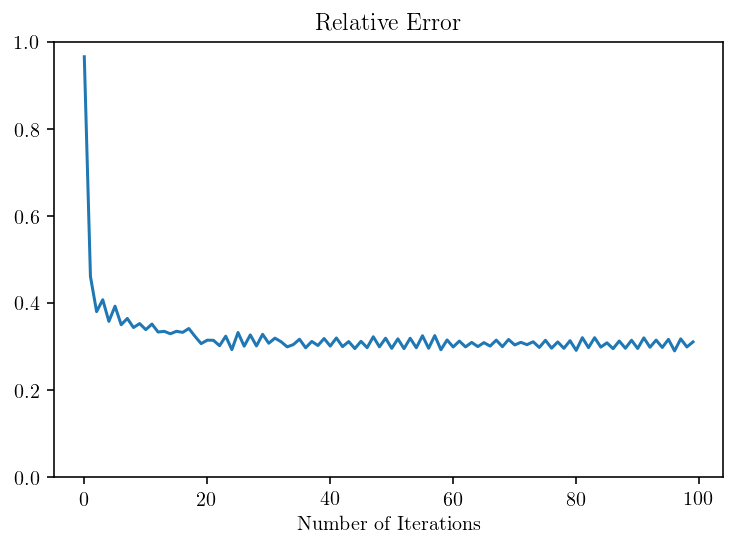

In [286]:
plt.plot(ks_err_track)
plt.title(r"Relative Error")
plt.ylim([0,1])
plt.xlabel(r"Number of Iterations")
plt.show()

This might be wiggling since the error is calculated by summing up a bunch of small errors

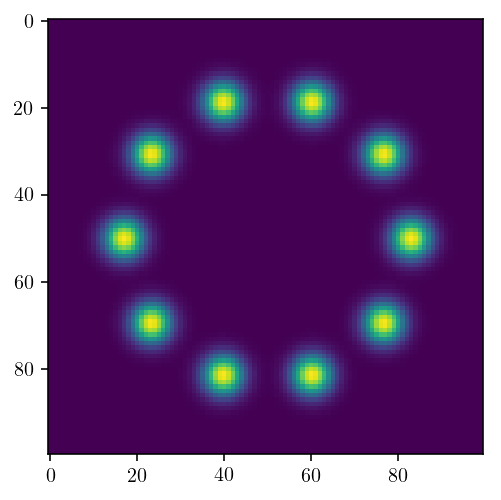

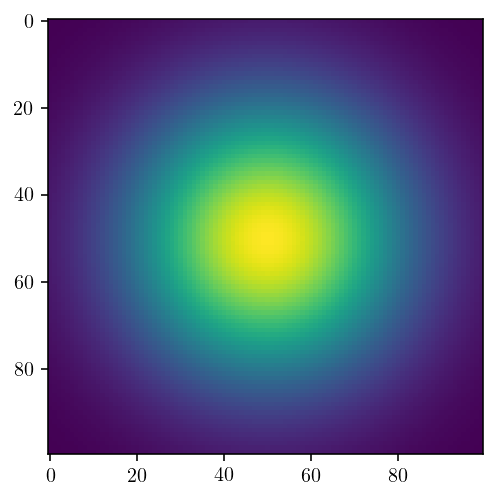

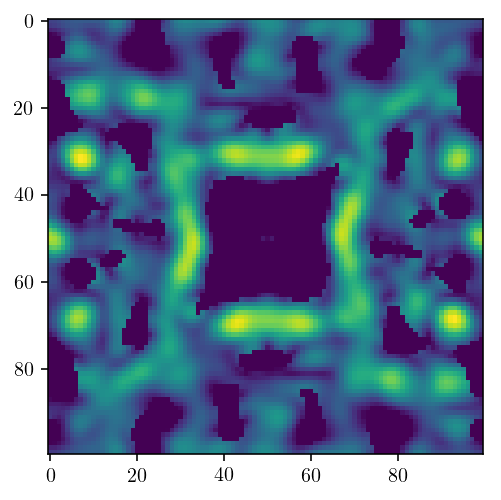

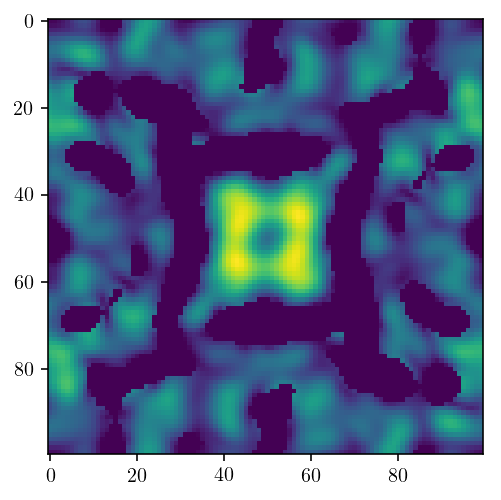

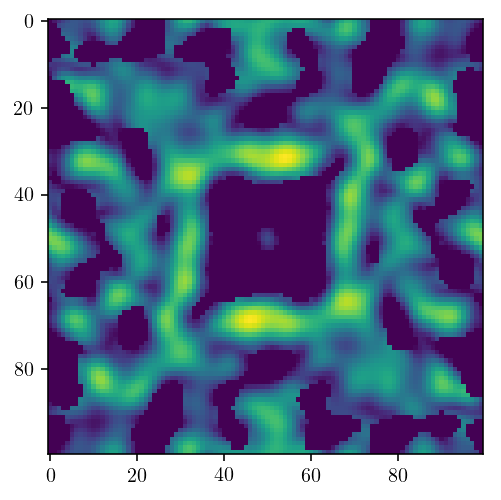

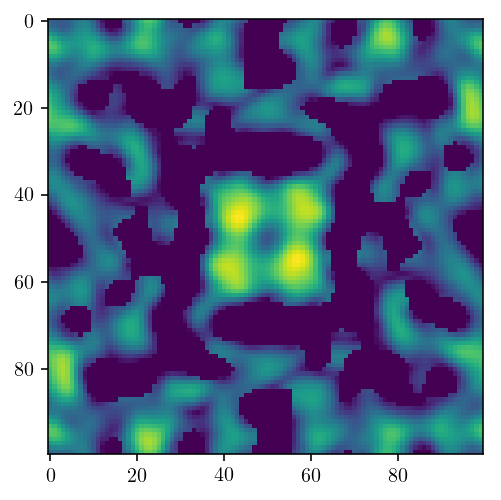

In [288]:
plt.imshow(uc)
plt.show()
for i in range(5):
    plt.imshow(rs_track[i])
    plt.show()

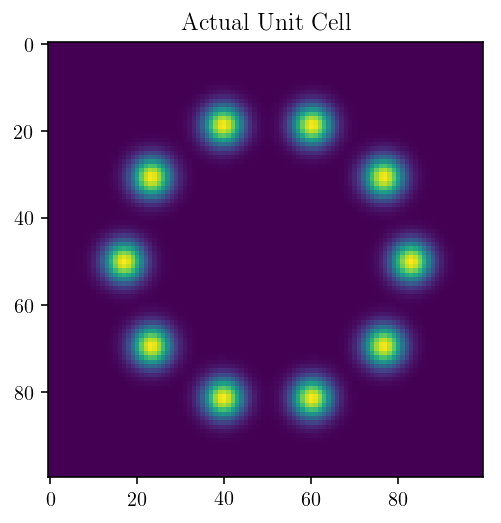

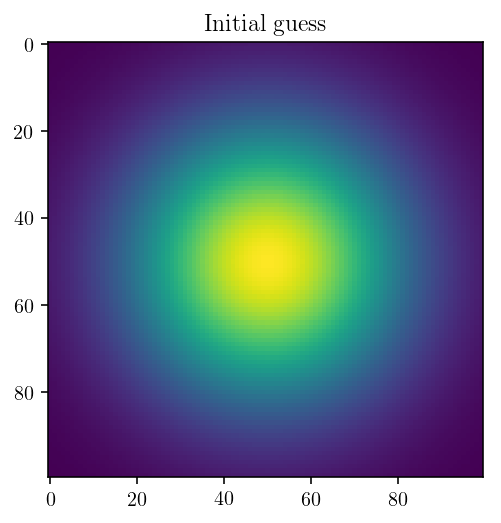

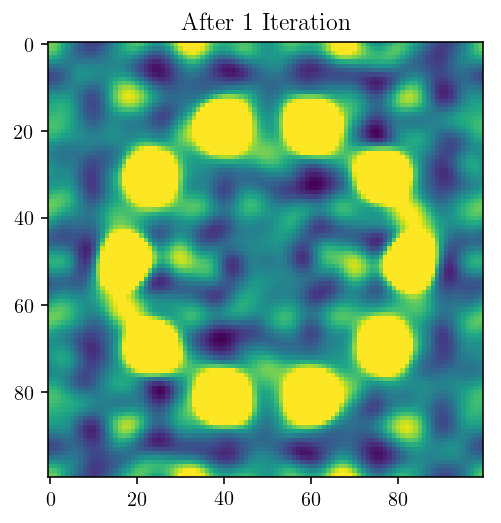

In [251]:
#This was made by cheating :( 
plt.imshow(uc)
plt.title(r"Actual Unit Cell")
plt.show()
plt.imshow(rs_track[0])
plt.title(r"Initial guess")
plt.show()
plt.imshow(-rs_track[1])
plt.title(r"After 1 Iteration")
plt.show()